# このファイルについて

衛星の熱設計における熱平衡方程式を解きます。
\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

アルベド項と赤外輻射項が時間変動するので厳しい。。。

頑張って

# Requirement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
import os

# 熱平衡方程式クラス

\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

In [380]:
class Thermal_eq:
    sigma = 5.670367e-8 #  Stefan–Boltzmann Constant

    def __init__(self,n_nodes,n_steps,dt):
        self.n_nodes = n_nodes
        self.n_steps = n_steps
        self.dt = dt
        
        self.time = np.arange(0,dt*n_steps,dt)              # 時間
        
        self.m = [1. for i in range(n_nodes)]                  # 質量
        self.c = [1. for i in range(n_nodes)]                  # 熱容量
        self.C = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # c[i,j]
        self.R = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # R[i,j]
        self.T_all = [[1. for i in range(n_nodes)] for j in range(n_steps)]    # 温度（横に時間軸）
        
        self.Q_in = [[0. for i in range(n_steps)] for j in range(n_nodes)]
        
    def set_params(self,param_m=None,param_C=None,param_c=None,param_R=None):
        if not param_m==None:
            assert len(param_m)==self.n_nodes, 'size of parameter m is different'
            self.m = param_m
        if not param_C==None:
            assert len(param_C)==self.n_nodes, 'size of parameter C is different'
            self.C = param_C
        if not param_c==None:
            assert len(param_c)==self.n_nodes, 'size of parameter c is different'
            self.c = param_c
        if not param_R==None:
            assert len(param_R)==self.n_nodes, 'size of parameter R is different'
            self.R = param_R
            
    def set_Q_in(self,n_node,Q_t):
        self.Q_in[n_node-1] = (np.array(Q_t) + np.array(self.Q_in[n_node-1])).tolist()
    
    def solve_eq(self,T_init):
        self.T_all[0] = T_init
        for i in range(self.n_steps-1):
            if i%5000==0:
                print('now at {0} step'.format(i))
            T_temp = self.T_all[i]
            k0 = self.get_dTdt(i,T_temp)
            k1 = self.get_dTdt(i,[T_temp[i] + k0[i]*self.dt/2 for i in range(self.n_nodes)])
            k2 = self.get_dTdt(i,[T_temp[i] + k1[i]*self.dt/2 for i in range(self.n_nodes)])
            k3 = self.get_dTdt(i,[T_temp[i] + k2[i]*self.dt for i in range(self.n_nodes)])
            k = [(k0[i] + 2*k1[i] + 2*k2[i] + k3[i])/6.0 for i in range(self.n_nodes)]
            self.T_all[i+1] = [T_temp[i] + k[i]*self.dt for i in range(self.n_nodes)]
    
    def get_dTdt(self,n_step,T):
        dTdt = [0 for i in range(self.n_nodes)]
        for i in range(self.n_nodes):
            sum_1 = sum([self.C[i][j]*(T[j]-T[i]) for j in range(self.n_nodes)])
            sum_2 = self.sigma * sum([self.R[i][j]*(T[j]**4-T[i]**4) for j in range(self.n_nodes)])
            dTdt[i] = (sum_1 + sum_2 + self.Q_in[i][n_step]) / self.m[i] / self.c[i]
        return dTdt
    
    def plot_Q(self,save=False):
        Q = np.array(self.Q_in)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'heat $\rm{[W/m^2]}$')
        for i in range(Q.shape[0]-1):
            plt.plot(self.time,Q[i],label='node {0}'.format(i+1))
        plt.legend()
        if save:
            plt.savefig('../../output/heat_in.png')
        
    def plot_T(self,save=False,name='temperature'):
        T = np.array(self.T_all)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'Temperature $\rm{[K]}$')
        for i in range(T.shape[1]-1):
            plt.plot(self.time,T[:,i],label='node {0}'.format(i+1))
        threshold = np.ones_like(self.time)
        
        #plt.plot(self.time,threshold*255,color='black')
        #plt.plot(self.time,threshold*243,color='black')
        #plt.plot(self.time,threshold*233,color='black')
        
        plt.legend()
        if save:
            plt.savefig('../../output/'+name+'.png',dpi=200)
            
    def export_data_to_csv(self,dir_name):
        if not os.path.exists('../../output/'+dir_name):
            os.mkdir('../../output/'+dir_name)
        pd.DataFrame(self.R).to_csv('../../output/'+dir_name+'/radiation_coupling.csv')
        pd.DataFrame(self.C).to_csv('../../output/'+dir_name+'/transfer_coupling.csv')
        #np.savetxt('../output/'+dir_name+'radiation_coupling.csv', pd.DataFrame(self.R), delimiter=",")
        #np.savetxt('../output/'+dir_name+'transfer_coupling.csv', pd.DataFrame(self.C), delimiter=",")
        

def new_alpha_and_eps(surface_rate,alpha,eps,n_node):
    solar_features = np.array([0.88,0.85])
    node_features = np.array([alpha[n_node],eps[n_node]])
    new_node = node_features*(1-surface_rate) + solar_features*surface_rate
    return new_node

In [7]:
Ps = 1358
Pe = 237
Pa = Ps*0.3

# フェーズ2

<img src="../../output/thermal_cylinder.png" width=30%>

$D_1 > D_3$

In [361]:
def get_F_12(D1,D5,L2,L4,L6):
    A1 = D1**2*np.pi/4
    a = D5/2
    b = D1/2
    A2 = np.pi*(D5/2+D1/2)*((D5/2-D1/2)**2+L2**2)**0.5
    F_21 = get_F_21(D1,D5,L2,L4,L6)
    F_12 = F_21 * A2/A1
    return F_12

def get_F_13(D1,D5,L2,L4,L6):
    return get_F_31(D5,D1,L2,L4,L6)

def get_F_21(D1,D5,L2,L4,L6):
    return get_F_23(D5,D1,L2,L4,L6)

def get_F_22(D1,D5,L2,L4,L6):
    temp = np.sqrt(L2**2+((D1-D5)**2)/4)
    x = temp*np.max([D1,D5])/np.abs(D1-D5)
    xi = x - temp
    theta = 2*np.arcsin(np.max([D1,D5])/2/x)
    X = xi/x
    return 1+((1-X)*np.cos(theta/2)**2 - np.sqrt((X+1)**2-4*X*np.cos(theta/2)**2))/((1+X)*np.sin(theta/2))

def get_F_23(D1,D5,L2,L4,L6):
    H = L2*2/D1
    R = D5/D1
    X = (1+R**2+H**2)
    return (2*R**2-X+(X**2-4*R**2)**0.5)/(2*(X-2*R)**0.5*(1+R))

def get_F_31(D1,D5,L2,L4,L6):
    a = D1/2
    b = D5/2
    return (a**2+b**2+L4**2-((a**2+b**2+L4**2)**2-4*a**2*b**2)**0.5)/2/b**2

def get_F_32(D1,D5,L2,L4,L6):
    A3 = D5**2*np.pi/4
    a = D5/2
    b = D1/2
    A2 = np.pi*(a+b)*((a-b)**2+L2**2)**0.5
    F_23 = get_F_23(D1,D5,L2,L4,L6)
    F_32 = F_23 * A2/A3
    return F_32

def get_F_34(D1,D5,L2,L4,L6):
    return get_F_54(D1,D5,L2,L4,L6) # 対称性より

def get_F_35(D1,D5,L2,L4,L6):
    return get_F_53(D1,D5,L2,L4,L6)

def get_F_43(D1,D5,L2,L4,L6):
    return get_F_45(D1,D5,L2,L4,L6) # 対称性より

def get_F_44(D1,D5,L2,L4,L6):
    H = L4/D5
    return 1 + H - np.sqrt(1+H**2)

def get_F_45(D1,D5,L2,L4,L6):
    A5 = np.pi*D5**2/4
    A4 = np.pi*2*D5*L4
    return get_F_54(D1,D5,L2,L4,L6) * A5/A4

def get_F_53(D1,D5,L2,L4,L6):
    H = L4/D5
    return 1+2*H**2 - 2*H*np.sqrt(1+H**2)

def get_F_54(D1,D5,L2,L4,L6):
    H = L4/D5
    return 2*H*(np.sqrt(H**2+1) - H)

def get_F_56(D1,D5,L2,L4,L6):
    H = L6/D5
    return 2*H*(np.sqrt(H**2+1) - H)

def get_F_57(D1,D5,L2,L4,L6):
    H = L6/D5
    return 1+2*H**2 - 2*H*np.sqrt(1+H**2)

def get_F_65(D1,D5,L2,L4,L6):
    A5 = np.pi*D5**2/4
    A6 = np.pi*2*D5*L6
    return get_F_56(D1,D5,L2,L4,L6) * A5/A6

def get_F_66(D1,D5,L2,L4,L6):
    H = L6/D5
    return 1 + H - np.sqrt(1+H**2)

def get_F_67(D1,D5,L2,L4,L6):
    A7 = np.pi*D5**2/4
    A6 = np.pi*2*D5*L6
    return get_F_76(D1,D5,L2,L4,L6) * A7/A6

def get_F_75(D1,D5,L2,L4,L6):
    H = L6/D5
    return 1+2*H**2 - 2*H*np.sqrt(1+H**2)

def get_F_76(D1,D5,L2,L4,L6):
    H = L6/D5
    return 2*H*(np.sqrt(H**2+1) - H)

def get_F(D1,D5,L2,L4,L6):
    F = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]
    F[0][1] = get_F_12(D1,D5,L2,L4,L6)
    F[0][2] = get_F_13(D1,D5,L2,L4,L6)
    F[1][0] = get_F_21(D1,D5,L2,L4,L6)
    F[1][1] = get_F_22(D1,D5,L2,L4,L6)
    F[1][2] = get_F_23(D1,D5,L2,L4,L6)
    F[2][0] = get_F_31(D1,D5,L2,L4,L6)
    F[2][1] = get_F_32(D1,D5,L2,L4,L6)
    F[2][3] = get_F_34(D1,D5,L2,L4,L6)
    F[2][4] = get_F_35(D1,D5,L2,L4,L6)
    F[3][2] = get_F_43(D1,D5,L2,L4,L6)
    F[3][3] = get_F_44(D1,D5,L2,L4,L6)
    F[3][4] = get_F_45(D1,D5,L2,L4,L6)
    F[4][2] = get_F_53(D1,D5,L2,L4,L6)
    F[4][3] = get_F_54(D1,D5,L2,L4,L6)
    F[4][5] = get_F_56(D1,D5,L2,L4,L6)
    F[4][6] = get_F_57(D1,D5,L2,L4,L6)
    F[5][4] = get_F_65(D1,D5,L2,L4,L6)
    F[5][5] = get_F_66(D1,D5,L2,L4,L6)
    F[5][6] = get_F_67(D1,D5,L2,L4,L6)
    F[6][4] = get_F_75(D1,D5,L2,L4,L6)
    F[6][5] = get_F_76(D1,D5,L2,L4,L6)
    return F

In [404]:
### 基本定数 ###
G = 6.67e-11
r_e = 6378 #地球の半径[km]
M_e = 5.9724e24

### ミッション定数 ###
D1 = 1.0
D5 = 2.0
L2 = 1.2
L4 = 1.2
L6 = 1.2

A = [np.pi*D1**2/4,
     np.pi*(D1/2+D5/2)*((D1/2-D5/2)**2+L2**2)**0.5,
     np.pi*D5**2/4,
     np.pi*D5*L4,
     np.pi*D5**2/4,
     np.pi*D5*L6,
     np.pi*D5**2/4,
     1e7]
alpha_o = [0.34,0.05,0.13,0.05,0.56,0.25,0.34,0.]
eps_o   = [0.55,0.80,0.78,0.80,0.88,0.85,0.55,1.]
alpha_i = [0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.]
eps_i   = [0.89,0.89,0.89,0.89,0.89,0.89,0.89,1.]

surface_rate = 0.97/((D1+D5)/2*L2 + D5*L4) # 太陽電池セルの占める面積の割合
alpha_o[1],eps_o[1] = new_alpha_and_eps(surface_rate,alpha_o,eps_o,1)
alpha_o[3],eps_o[3] = new_alpha_and_eps(surface_rate,alpha_o,eps_o,3)

n_nodes = 8
m_i = [50,100,700,50,600,50,1000,100]
c_i = [0.8 for i in range(n_nodes)]
c_i[n_nodes-1] = 1e7
C_ij = (1 * np.array([
       [0. ,17.,0. ,0. ,0. ,0. ,0. ,0. ],
       [17.,0. ,17.,4. ,0. ,0. ,0. ,0. ],       
       [0. ,17.,0. ,17.,0. ,0. ,0. ,0. ],
       [0. ,4. ,17.,0. ,17.,0. ,0. ,0. ],
       [0. ,0. ,0. ,17.,0. ,17.,0. ,0. ],
       [0. ,0. ,0. ,0. ,17.,0. ,17.,0. ],
       [0. ,0. ,0. ,0. ,0. ,17.,0. ,0. ],
       [0. ,0. ,0. ,0. ,0. ,0. ,0. ,0. ]
       ])).tolist()

F = get_F(D1,D5,L2,L4,L6)

R_ij = [
     [F[0][0]*eps_i[0]*eps_i[0]*A[0]/2, F[0][1]*eps_i[0]*eps_i[1]*A[0]/2, F[0][2]*eps_i[0]*eps_i[2]*A[0]/2,
      F[0][3]*eps_i[0]*eps_i[3]*A[0]/2, F[0][4]*eps_i[0]*eps_i[4]*A[0]/2, F[0][5]*eps_i[0]*eps_i[5]*A[0]/2,
      F[0][6]*eps_i[0]*eps_i[6]*A[0]/2, 0.5*eps_o[0]*eps_o[7]*A[0]],
     [F[1][0]*eps_i[1]*eps_i[0]*A[1]/2, F[1][1]*eps_i[1]*eps_i[1]*A[1]/2, F[1][2]*eps_i[1]*eps_i[2]*A[1]/2,
      F[1][3]*eps_i[1]*eps_i[3]*A[1]/2, F[1][4]*eps_i[1]*eps_i[4]*A[1]/2, F[1][5]*eps_i[1]*eps_i[5]*A[1]/2,
      F[1][6]*eps_i[1]*eps_i[6]*A[1]/2, 0.5*eps_o[1]*eps_o[7]*A[1]],
     [F[2][0]*eps_i[2]*eps_i[0]*A[2]/2, F[2][1]*eps_i[2]*eps_i[1]*A[2]/2, F[1][2]*eps_i[2]*eps_i[2]*A[2]/2,
      F[2][3]*eps_o[2]*eps_i[3]*A[2]/2, F[2][4]*eps_o[2]*eps_i[4]*A[2]/2, F[1][5]*eps_o[2]*eps_i[5]*A[2]/2,
      F[2][6]*eps_o[2]*eps_i[6]*A[2]/2, 0.0*eps_o[2]*eps_o[7]*A[2]],
     [F[3][0]*eps_i[3]*eps_i[0]*A[3]/2, F[3][1]*eps_i[3]*eps_i[1]*A[3]/2, F[0][2]*eps_i[3]*eps_o[2]*A[3]/2,
      F[3][3]*eps_i[3]*eps_i[3]*A[3]/2, F[3][4]*eps_i[3]*eps_i[4]*A[3]/2, F[0][5]*eps_i[3]*eps_i[5]*A[3]/2,
      F[3][6]*eps_i[3]*eps_i[6]*A[3]/2, 0.5*eps_o[3]*eps_o[7]*A[3]],
     [F[4][0]*eps_i[4]*eps_i[0]*A[4]/2, F[4][1]*eps_i[4]*eps_i[1]*A[4]/2, F[1][2]*eps_i[4]*eps_o[2]*A[4]/2,
      F[4][3]*eps_i[4]*eps_i[3]*A[4]/2, F[4][4]*eps_i[4]*eps_i[4]*A[4]/2, F[1][5]*eps_o[4]*eps_i[5]*A[4]/2,
      F[4][6]*eps_o[4]*eps_i[6]*A[4]/2, 0.0*eps_o[4]*eps_o[7]*A[4]],
     [F[5][0]*eps_i[5]*eps_i[0]*A[5]/2, F[5][1]*eps_i[5]*eps_i[1]*A[5]/2, F[1][2]*eps_i[5]*eps_o[2]*A[5]/2,
      F[5][3]*eps_i[5]*eps_i[3]*A[5]/2, F[5][4]*eps_i[5]*eps_i[4]*A[5]/2, F[1][5]*eps_i[5]*eps_o[5]*A[5]/2,
      F[5][6]*eps_i[5]*eps_i[6]*A[5]/2, 0.5*eps_o[5]*eps_o[7]*A[5]],
     [F[6][0]*eps_i[6]*eps_i[0]*A[6]/2, F[6][1]*eps_i[6]*eps_i[1]*A[6]/2, F[1][2]*eps_i[6]*eps_o[2]*A[6]/2,
      F[6][3]*eps_i[6]*eps_i[3]*A[6]/2, F[6][4]*eps_i[6]*eps_i[4]*A[6]/2, F[1][5]*eps_i[6]*eps_o[5]*A[6]/2,
      F[6][6]*eps_i[6]*eps_i[6]*A[6]/2, 0.5*eps_o[6]*eps_o[7]*A[6]],
     [0.,0.,0.,0.,0.,0.,0.,0.]
]

r = 1200 + r_e
T_rev = 2*math.pi*math.sqrt((r*10**3)**3/G/M_e)

In [405]:
### 計算用の定数決定 ###
dt = 0.5
n_steps = 1000

In [406]:
def get_Q7(n_steps,A,alpha,eps):
    A7_project_7 = D5**2*np.pi/4
    return ((alpha[6] * A7_project_7 * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q6_side(n_steps,A,alpha,eps):
    A6_project_side = D5*L6
    return ((alpha[5] * A6_project_side * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q4_side(n_steps,A,alpha,eps):
    A4_project_side = D5*L4
    return ((alpha[3] * A4_project_side * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q2_side(n_steps,A,alpha,eps):
    A2_project_side = (D1+D5)*L2/2
    return ((alpha[1] * A2_project_side * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q2_1(n_steps,A,alpha,eps):
    A2_project_1 = (D5**2-D1**2)*np.pi/4
    return ((alpha[3] * A2_project_1 * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q1_1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q_components(n_steps,W):
    return (W*np.ones(n_steps)).tolist()

now at 0 step


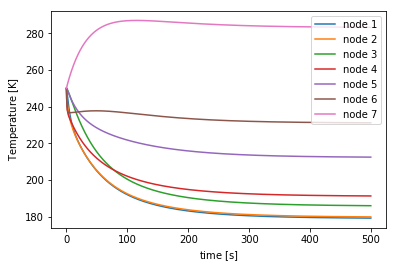

In [407]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(7,get_Q7(n_steps,A,alpha_o,eps_o))
#eq.set_Q_in(4,get_Q_components(n_steps,10))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase1_temp7')

now at 0 step


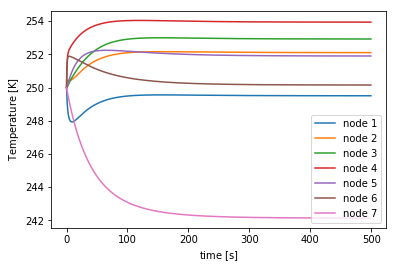

In [385]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(2,get_Q2_side(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(4,get_Q4_side(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(6,get_Q6_side(n_steps,A,alpha_o,eps_o))
#eq.set_Q_in(4,get_Q_components(n_steps,10))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase1_temp246')

now at 0 step


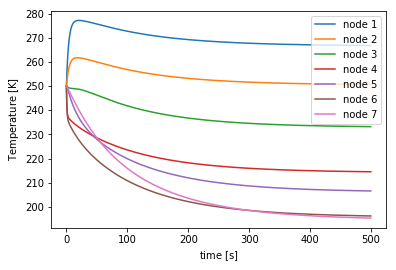

In [386]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(1,get_Q1_1(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(2,get_Q2_1(n_steps,A,alpha_o,eps_o))
#eq.set_Q_in(4,get_Q_components(n_steps,10))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase1_temp1')

## フェーズ2

In [387]:
def get_Q5(n_steps,A,alpha,eps):
    A5_project_5 = D5**2*np.pi/4
    return ((alpha[4] * A5_project_5 * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q4_side(n_steps,A,alpha,eps):
    A4_project_side = D5*L4
    return ((alpha[3] * A4_project_side * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q2_side(n_steps,A,alpha,eps):
    A2_project_side = (D1+D5)*L2/2
    return ((alpha[1] * A2_project_side * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q2_1(n_steps,A,alpha,eps):
    A2_project_1 = (D5**2-D1**2)*np.pi/4
    return ((alpha[3] * A2_project_1 * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q1_1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()

def get_Q_components(n_steps,W):
    return (W*np.ones(n_steps)).tolist()

In [388]:
def delete_phase2(Mat):
    Ans = np.delete(Mat,[5,6],0)
    return np.delete(Ans,[5,6],1).tolist()

m_i_2 = np.delete(m_i,[5,6]).tolist()
c_i_2 = np.delete(c_i,[5,6]).tolist()

C_ij_2 = delete_phase2(C_ij)
R_ij_2 = delete_phase2(R_ij)
R_ij_2[4][5] = 0.5*eps_o[4]*eps_o[7]*A[4]

In [408]:
eq.export_data_to_csv('capsule_final')

### 節点5に入熱

now at 0 step


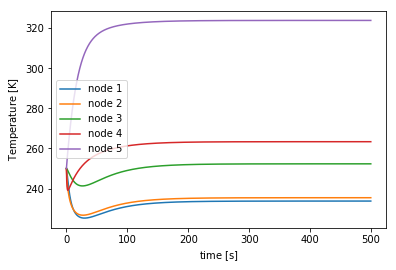

In [389]:
eq = Thermal_eq(n_nodes=n_nodes_2,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_2,param_C=C_ij_2,param_c=c_i_2,param_R=R_ij_2)
eq.set_Q_in(5,get_Q5(n_steps,A,alpha_o,eps_o))
#eq.set_Q_in(4,get_Q_components(n_steps,10))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase2_temp5')

### 横から入熱

now at 0 step


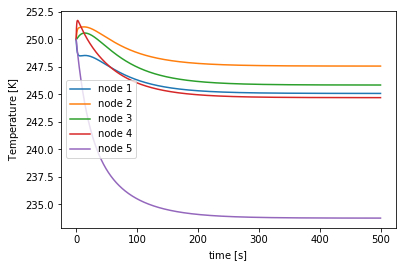

In [390]:
eq = Thermal_eq(n_nodes=n_nodes_2,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_2,param_C=C_ij_2,param_c=c_i_2,param_R=R_ij_2)
eq.set_Q_in(2,get_Q2_side(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(4,get_Q4_side(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(2,get_Q_components(n_steps,30))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase2_temp24')

### 節点1,2に入熱

now at 0 step


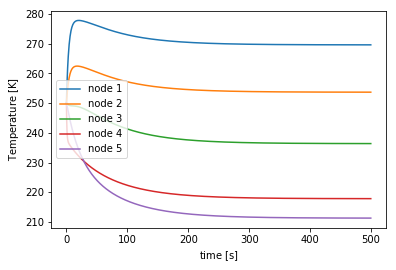

In [391]:
eq = Thermal_eq(n_nodes=n_nodes_2,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_2,param_C=C_ij_2,param_c=c_i_2,param_R=R_ij_2)
eq.set_Q_in(2,get_Q2_1(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(1,get_Q1_1(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(2,get_Q_components(n_steps,30))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase2_temp1')

# フェーズ3

In [393]:
def delete_phase3(Mat):
    Ans = np.delete(Mat,[3,4,5,6],0)
    return np.delete(Ans,[3,4,5,6],1).tolist()

m_i_3 = np.delete(m_i,[3,4,5,6]).tolist()
c_i_3 = np.delete(c_i,[3,4,5,6]).tolist()

C_ij_3 = delete_phase3(C_ij)
R_ij_3 = delete_phase3(R_ij)
R_ij_3[2][3] = 0.5*eps_o[2]*eps_o[7]*A[2]

In [394]:
def get_Q1_1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2_1(n_steps,A,alpha,eps):
    A2_project_1 = (D5**2-D1**2)*np.pi/4
    return ((alpha[1] * A2_project_1 * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2_2(n_steps,A,alpha,eps):
    A2_project_2 = (D1+D5)*L4/2
    return ((alpha[1] * A2_project_2 * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q3(n_steps,A,alpha,eps):
    return ((alpha[2] * A[2] * 1 * Ps)*np.ones(n_steps)).tolist()

## 節点3に入熱

now at 0 step


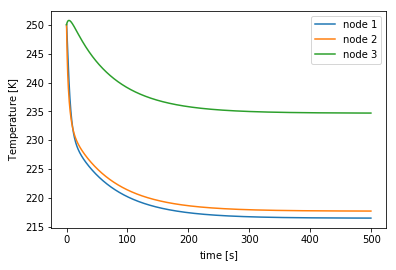

In [395]:
eq = Thermal_eq(n_nodes=n_nodes-4,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_3,param_C=C_ij_3,param_c=c_i_3,param_R=R_ij_3)
eq.set_Q_in(3,get_Q3(n_steps,A,alpha_o,eps_o))
T_init = [250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase3_temp3')

## 横から入熱

now at 0 step


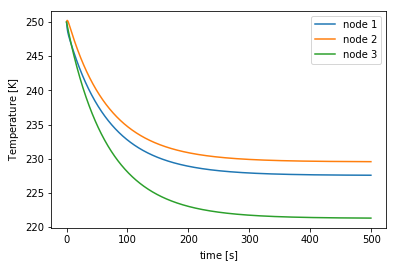

In [396]:
eq = Thermal_eq(n_nodes=n_nodes-4,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_3,param_C=C_ij_3,param_c=c_i_3,param_R=R_ij_3)
eq.set_Q_in(2,get_Q2_2(n_steps,A,alpha_o,eps_o))
T_init = [250.,250.,250.,3.]
#eq.set_Q_in(2,get_Q_components(n_steps,300))
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase3_temp2')

## 節点1,2に入熱

now at 0 step


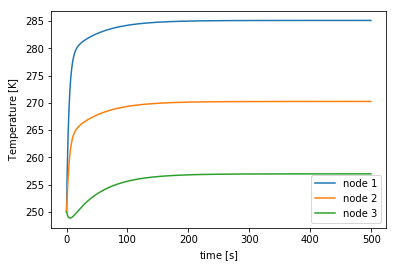

In [397]:
eq = Thermal_eq(n_nodes=n_nodes-4,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i_3,param_C=C_ij_3,param_c=c_i_3,param_R=R_ij_3)
eq.set_Q_in(1,get_Q1_1(n_steps,A,alpha_o,eps_o))
eq.set_Q_in(2,get_Q2_1(n_steps,A,alpha_o,eps_o))
T_init = [250.,250.,250.,3.]
#eq.set_Q_in(2,get_Q_components(n_steps,300))
eq.solve_eq(T_init)
eq.plot_T(save=True,name='phase3_temp1')